Best fit distribution: lognorm
Parameters: (0.2603474034694083, -30.027730358141586, 65.27315692270236)


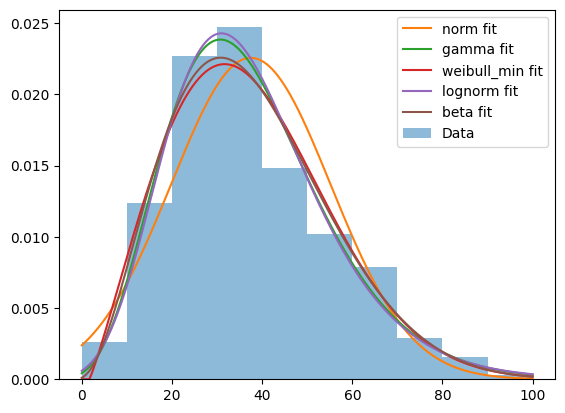

Score 55 is in the 84.5079 percentile


In [23]:
import pytesseract
import numpy as np
from scipy.stats import mode
from PIL import Image 
from PIL import ImageEnhance
from scipy.stats import norm, gamma, weibull_min, lognorm, beta
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
import pandas as pd
from tqdm import tqdm

pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'

conf_threshold = 50
bottom_buffer = 0

def crop_out_blue(input_img):
    image = input_img.convert("RGB")
    pixels = image.load()
    width, height = image.size
    top = height

    middle_start = width // 4  # Start 25% into the width
    middle_end = 3 * width // 4  # End 75% into the width

    for y in range(height):
        for x in range(middle_start, middle_end):
            r, g, b = pixels[x, y]
            if b > 150 and b > r + 50 and b > g + 50:
                top = min(top, y)

    # if top == height:
        # print("No blue region detected in the bottom crop.")
    cropped_image = image.crop((0, 0, width, top))

    cropped_pixels = cropped_image.load()
    cropped_width, cropped_height = cropped_image.size
    left = 0
    right = cropped_width

    # Check the left edge
    for x in range(cropped_width // 2):  # Only analyze the left half
        found_blue = False
        for y in range(cropped_height):
            r, g, b = cropped_pixels[x, y]
            if (b > 150 and b > r + 50 and b > g + 50):
                left = x
                found_blue = True
                break
        if not found_blue:
            break

    # Check the right edge
    for x in range(cropped_width - 1, cropped_width // 2, -1):  # Only analyze the right half
        found_blue = False
        for y in range(cropped_height):
            r, g, b = cropped_pixels[x, y]
            if (b > 150 and b > r + 50 and b > g + 50):
                right = x
                found_blue = True
                break
        if not found_blue:
            break

    if left < right:
        cropped_image = cropped_image.crop((left, 0, right, cropped_height))
    # else:
        # print("No valid region after horizontal crop.")
    return cropped_image


def image_to_bins (image_folder):
    image = Image.open(f"figures/{image_folder}/{image_folder}.png")

    # # TODO: Consider image preprocessing here
    # enhancer = ImageEnhance.Contrast(image) # TODO: A/B TEST IF ENHANCER WORKS
    # image = enhancer.enhance(2)

    bottoms = []
    x_s = []

    data = pytesseract.image_to_data(image, config='--psm 6', output_type=pytesseract.Output.DICT)
    target_number = 0
    still_targeting = True
    bins = []
    while still_targeting :
        bins.append(target_number)
        target_number += 10
        for i, text in enumerate(data["text"]):
            if text == str(target_number):  # Match the target number
                x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
                bottoms.append(y)
                x_s.append(x)
                # print(f"Found '{target_number}' at (x={x}, y={y}), width={w}, height={h}")
                break
        else: # not in for loop
            # print(f"'{target_number}' not found in the image.")
            still_targeting = False

    confidence = mode(bottoms)[1] / len(bottoms) * 100
    assert confidence > conf_threshold, f"hella low confidence: {confidence}%"
    bottom_crop = mode(bottoms)[0]
    bottom_crop -= bottom_buffer
    # print(f"{bottom_crop}, {confidence}% confidence")

    diffs = np.diff(np.array(x_s))
    argmedian = np.argsort(diffs)[len(diffs)//2] # 0-indexed
    median = np.median(diffs)


    strips = []
    for i in range(len(x_s)):
        elem = ((i - 1 - argmedian) * median + x_s[argmedian], (i - argmedian) * median + x_s[argmedian])
        strips.append(elem)
        # print(elem)

    ret = []
    for i, (start_x, end_x) in enumerate(strips):
        cropped = image.crop((start_x, 0, end_x, bottom_crop))  # (left, upper, right, lower)
        path = f"figures/{image_folder}/strip_{i + 1}.png"
        cropped.save(path)
        # print(f"Saved strip_{i + 1}.jpg")
        img = Image.open(path)

        img = crop_out_blue(img)

        # width, height = img.size
        # if height > 350:
        #     # print("yes")
        #     img = img.crop((0, 200, width, height))

        img = img.convert("L")
        enhancer = ImageEnhance.Contrast(img) # TODO: Atest other processings
        img = enhancer.enhance(2)


        special_path = f"figures/{image_folder}/strip_{i + 1}_special.png"
        img.save(special_path)

        # 1, 3, 4 and 6
        text = pytesseract.image_to_string(img, config='--psm 6 digits')
        # print(text.split("\n")[0])

        if not text:
            text = "0\n"
            print("SOME VALUE NOT FOUND, FILLED AS 0")

        ret.append(int(text[:-1]))

    assert len(ret) == len(bins) - 1, "bin value mismatch"
    return bins, ret

def plot_histogram(bin_edges, bin_values, plot=True):
    # Generate sample points from histogram
    sample_points = []
    for i in range(len(bin_values)):
        sample_points.extend(np.repeat(np.mean([bin_edges[i], bin_edges[i+1]]), bin_values[i]))

    # List of distributions to test
    distributions = [norm, gamma, weibull_min, lognorm, beta]
    fitted_params = {}
    ks_metrics = {}

    # Fit distributions and compute KS metric
    for dist in distributions:
        try:
            params = dist.fit(sample_points) # Uses MLE ?
            fitted_params[dist] = params
            ks_stat, p_value = kstest(sample_points, dist.cdf, args=params)
            ks_metrics[dist] = (ks_stat, p_value)
        except Exception as e:
            print(f"Failed to fit {dist.name}: {e}")

    # Find the best fit based on the highest p-value
    best_fit = max(ks_metrics, key=lambda d: ks_metrics[d][1])
    if plot:
        print(f"Best fit distribution: {best_fit.name}")
        print(f"Parameters: {fitted_params[best_fit]}")

    if plot:
        # Plot the results
        plt.hist(sample_points, bins=bin_edges, density=True, alpha=0.5, label="Data")

        x = np.linspace(min(bin_edges), max(bin_edges), 1000)
        for dist, params in fitted_params.items():
            pdf = dist.pdf(x, *params)
            plt.plot(x, pdf, label=f"{dist.name} fit")

        plt.legend()
        plt.show()

    return best_fit, fitted_params[best_fit]

def score_to_percentile(score, dist, params):
    return dist.cdf(score, *params)

def main(score, image):
    bin_edges, bin_values = image_to_bins(image)
    best_fit, params = plot_histogram(bin_edges, bin_values)
    print(f"Score {score} is in the {round(score_to_percentile(score, best_fit, params) * 100, 4)} percentile")

score = 55
main(score, "1")


No handles with labels found to put in legend.


     Score  Main Value  Normal Value     Error
0        0      0.1430      2.557290  2.414290
1        1      0.2141      2.913074  2.698974
2        2      0.3122      3.309047  2.996847
3        3      0.4440      3.748343  3.304343
4        4      0.6174      4.234147  3.616747
..     ...         ...           ...       ...
96      96     99.4249     99.974604  0.549704
97      97     99.4728     99.979462  0.506662
98      98     99.5167     99.983441  0.466741
99      99     99.5571     99.986689  0.429589
100    100     99.5941     99.989332  0.395232

[101 rows x 4 columns]


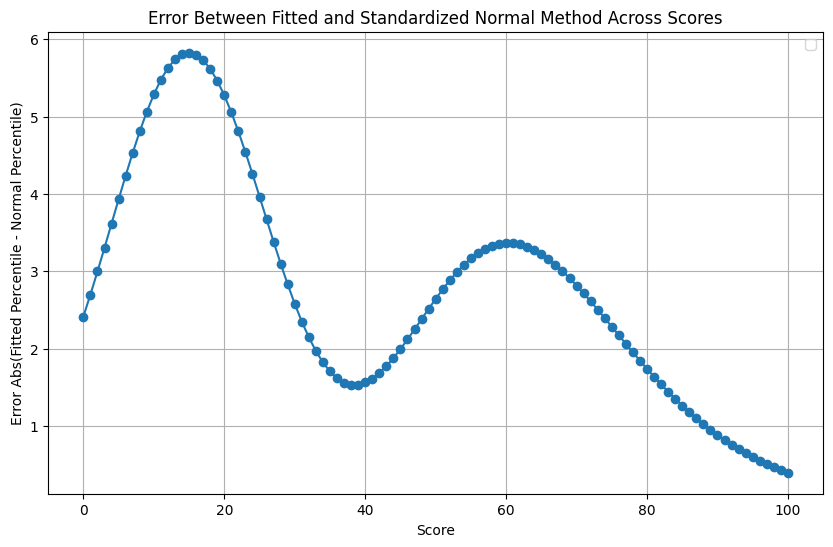

In [31]:
def array_main(scores, image):
    bin_edges, bin_values = image_to_bins(image)
    best_fit, params = plot_histogram(bin_edges, bin_values, False)
    percentiles = []
    for score in scores:
        percentiles.append(round(score_to_percentile(score, best_fit, params) * 100, 4))
    return percentiles

scores = np.arange(0, 101)
main_values = array_main(scores, "1")
main_values = np.array(main_values)
normal_values = norm.cdf(scores, loc=34.5, scale=17.69)*100

errors = np.abs(main_values - normal_values)

df = pd.DataFrame({
    "Score": scores,
    "Main Value": main_values,
    "Normal Value": normal_values,
    "Error": errors
})

print(df)

# Plot the errors
plt.figure(figsize=(10, 6))
plt.plot(scores, errors, marker='o', linestyle='-')
# plt.axhline(0, color='r', linestyle='--', label='Zero Error Line')
plt.title('Error Between Fitted and Standardized Normal Method Across Scores')
plt.xlabel('Score')
plt.ylabel('Error Abs(Fitted Percentile - Normal Percentile)')
plt.legend()
plt.grid(True)
plt.show()
